# CNN-LSTM for fall detection
Group : Yemi, Dongzi, Harkey, Sidd, Solène

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf

# KinectData

In [2]:
NDH = np.zeros((1,112))
labels = np.zeros((1,1))

RK = pd.DataFrame()
Labels = pd.DataFrame()

actions = ['walk', 'run', 'jump', 'legup', 'pickup', 'walk2', 'highfall', 'sitandup', 'movewithchair', 'fallchair', 'upsitbed', 'uplyingbed', 'fallbed']
for i in range(1,7) :
    for a in actions :
        try :
            labels_i = pd.read_csv("DATA/Test_data/KinectData/S1/S1P19K"+str(i)+"_" + a + "_cut_label.csv", index_col = 0)
            NDH_i = pd.read_csv("DATA/Test_data/KinectData/S1/S1P19K" + str(i) + "_" + a + "_RegKey.csv", header=None)
            if (len(labels_i) == len(NDH_i)) :
                print(i,a)
                
                df_lab = pd.DataFrame(labels_i)
                df_ndh = pd.DataFrame(NDH_i)

                video_name = "S1P19K"+str(i)+"_" + a 
                video_lab = [video_name] * len(df_lab)
                video_ndh = [video_name] * len(df_ndh)
                df_lab['Video'] = video_lab
                df_ndh['Video'] = video_ndh
                
                frame_ndh = [RK, df_ndh]
                frame_lab = [Labels, df_lab]
                RK = pd.concat(frame_ndh,axis = 0)
                Labels = pd.concat(frame_lab,axis = 0)            
            
        except :
            pass


#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
RK = RK.set_index('Video')
del RK[0]
Labels = Labels.set_index('Video')
print(RK)
print(Labels)

1 walk
1 run
1 jump
1 legup
1 pickup
1 walk2
1 highfall
1 sitandup
1 movewithchair
1 fallchair
1 upsitbed
1 uplyingbed
1 fallbed
2 run
2 jump
2 legup
2 pickup
2 walk2
2 highfall
2 sitandup
2 movewithchair
2 fallchair
2 upsitbed
3 run
3 jump
3 legup
3 pickup
3 walk2
3 highfall
3 sitandup
3 movewithchair
4 run
4 jump
4 legup
4 pickup
4 walk2
4 highfall
4 sitandup
4 upsitbed
4 uplyingbed
5 run
5 jump
5 legup
5 pickup
5 walk2
5 highfall
5 sitandup
5 movewithchair
5 upsitbed
5 uplyingbed
6 sitandup
6 fallchair
6 upsitbed
6 uplyingbed
                    1    2    3    4    5    6    7    8    9    10   ...  \
Video                                                                 ...   
S1P19K1_walk        1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1P19K1_walk        1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1P19K1_walk        1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1P19K1_walk        1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1P

In [45]:
lookback = 1
batch_size = 1

x_train_final = np.zeros((1,lookback,112))
y_train_final = np.zeros((1,1))


for i in range(1,7):
    for a in actions :
        try:
            y_train = Labels.loc[["S1P19K"+str(i)+"_" + a]]['label'].values
            y_train = y_train.reshape(-1,1)

            x_train = RK.loc[["S1P19K"+str(i)+"_" + a]].values

            scaler = MinMaxScaler()
            scaler.fit(x_train)
            x_train_scaled = scaler.transform(x_train)
            #print(x_train_scaled)

            #time series generator 
            ts_generator = keras.preprocessing.sequence.TimeseriesGenerator(x_train_scaled,y_train,length=lookback,batch_size=batch_size)
            x_ts = ts_generator[0][0]
            y_ts = ts_generator[0][1]

            #print(x_ts)
            #print(y_ts)

            for j in range(1,len(ts_generator)):
                #concatenate the series together
                x_ts = np.concatenate((x_ts,ts_generator[j][0]))
                y_ts = np.concatenate((y_ts,ts_generator[j][1]))

            #concatenate the series of every airplane to the final matrix
            x_train_final = np.concatenate((x_train_final,x_ts),axis = 0)
            y_train_final = np.concatenate((y_train_final,y_ts),axis = 0)
            
        except:
            pass

 # removing the first row because its composed of zeros when we created the matrices
x_train_final = x_train_final[1:]
y_train_final = y_train_final[1:]

In [46]:
print(x_train_final.shape)
print(y_train_final.shape)
print(x_train_final)
print(y_train_final)
#54 videos

(36013, 1, 112)
(36013, 1)
[[[1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 1. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


## 1) 1D CNN-LSTM

In [47]:
x_train_final = x_train_final.reshape(len(x_train_final),112)
x_train_final = x_train_final.reshape(len(x_train_final),8,14)
x_train_final = x_train_final.reshape(len(x_train_final),8,14,1)

model = keras.Sequential()
# define CNN model
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(32,2,activation='relu', input_shape = (8,14))))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
# define LSTM model
model.add(keras.layers.LSTM(160,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

## 2) 2D CNN-LSTM

In [36]:
frame_batch = 10

x_train_final = x_train_final[:np.int64(len(x_train_final)/frame_batch)*frame_batch, :, :]
y_train_final = y_train_final[:np.int64(len(y_train_final)/frame_batch)*frame_batch, :]

x_train_final = x_train_final.reshape(np.int64(len(x_train_final)/frame_batch),frame_batch,8,14,1)
y_train_final = y_train_final.reshape(np.int64(len(y_train_final)/frame_batch),frame_batch,1)

print(x_train_final.shape)
print(y_train_final.shape)

(3601, 10, 8, 14, 1)
(3601, 10, 1)


In [37]:
#Faster
model = keras.Sequential()
# define CNN model
model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape = (frame_batch,8,14))))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling2D((3,3))))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
# define LSTM model
model.add(keras.layers.LSTM(160,activation='relu'))
model.add(keras.layers.Dense(frame_batch,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

## 3) 3D CNN-LSTM

In [117]:
#Longer
frame_batch = 10

x_train_final = x_train_final[:np.int64(len(x_train_final)/frame_batch)*frame_batch, :, :]
y_train_final = y_train_final[:np.int64(len(y_train_final)/frame_batch)*frame_batch, :]

x_train_final = x_train_final.reshape(np.int64(len(x_train_final)/frame_batch),frame_batch,8,14,1,1)
y_train_final = y_train_final.reshape(np.int64(len(y_train_final)/frame_batch),frame_batch,1)

In [118]:
x_train_final = x_train_final.reshape(len(x_train_final),1,frame_batch,8,14,1)

print(x_train_final.shape)
print(y_train_final.shape)

model = keras.Sequential()
# define CNN model
model.add(keras.layers.TimeDistributed(keras.layers.Conv3D(32,(2,2,2),activation='relu', input_shape = (frame_batch,8,14,1))))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling3D((2,2,2))))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
# define LSTM model
model.add(keras.layers.LSTM(160,activation='relu'))
model.add(keras.layers.Dense(frame_batch,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

(3601, 1, 10, 8, 14, 1)
(3601, 10, 1)


## Model creation

In [62]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(x_train_final,y_train_final,epochs=25,batch_size = 20, validation_split = 0.2) #callbacks=[early_stopping_callback]

Epoch 1/25
1441/1441 [==============================] - 16s 11ms/step - loss: 0.0423 - val_loss: 1.1348
Epoch 2/25
1441/1441 [==============================] - 13s 9ms/step - loss: 0.0407 - val_loss: 1.1490
Epoch 3/25
1441/1441 [==============================] - 16s 11ms/step - loss: 0.0415 - val_loss: 1.0575
Epoch 4/25
1441/1441 [==============================] - 18s 12ms/step - loss: 0.0389 - val_loss: 1.5196
Epoch 5/25
1441/1441 [==============================] - 17s 12ms/step - loss: 0.0391 - val_loss: 1.3583
Epoch 6/25
1441/1441 [==============================] - 15s 10ms/step - loss: 0.0386 - val_loss: 1.2521
Epoch 7/25
 683/1441 [=============>................] - ETA: 7s - loss: 0.0364

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

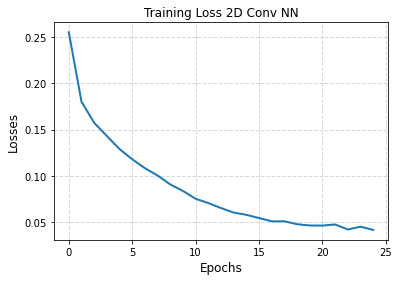

<Figure size 432x288 with 0 Axes>

In [49]:
pd.DataFrame(model.history.history["loss"]).plot(linestyle = "-",linewidth=2)
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, alpha=0.4)
plt.xlabel("Epochs",fontdict = {"fontsize": 12}) #number of epochs
plt.ylabel("Losses",fontdict = {"fontsize": 12}) #label the loss
plt.title("Training Loss 2D Conv NN",fontdict = {"fontsize": 12})
plt.legend().set_visible(False)
plt.savefig('Training Loss 2D Conv NN.jpg')
plt.figure()

In [226]:
RegKey_label_predict = np.round(model.predict(RegKey_test))

M_conf = np.zeros((2,2))
for i in range(len(RegKey_label_predict)) :
    if (RegKey_label_predict[i] == 1 and RegKey_label_true[i] == 1) :
        M_conf[0,0] += 1
    if (RegKey_label_predict[i] == 1 and RegKey_label_true[i] == 0) :
        M_conf[0,1] += 1
    if (RegKey_label_predict[i] == 0 and RegKey_label_true[i] == 1) :
        M_conf[1,0] += 1
    if (RegKey_label_predict[i] == 0 and RegKey_label_true[i] == 0) :
        M_conf[1,1] += 1

print(M_conf)
print("Accuracy = ", np.round((M_conf[0,0] + M_conf[1,1])*100/len(RegKey_label_true),1),' %')

#print(RegKey_label_true)
#print(RegKey_label_predict)

[[16.  0.]
 [23. 46.]]
Accuracy =  72.9  %


# Fall dataset in MoveNet

In [269]:
REGKEY = pd.DataFrame()
LABELS = pd.DataFrame()

Falls = ["00003","00004","00005","00006","00007","00008","00009","00010","00011","00012","00013","00014","00015","00016"]

for fall_number in Falls :
    REGKEY_i = pd.read_csv('DATA/Falls_MoveNet/Fall_'+fall_number+'_RegKey.csv', header = None).values[:,1:]
    LABELS_i = pd.read_csv('DATA/Falls_MoveNet/Fall_'+fall_number+'_label.csv',index_col = 0)
    
    df = pd.DataFrame(REGKEY_i)
    video_name = "Fall_" + fall_number
    video = [video_name] * len(df)
    df['Video'] = video
                
    frame = [REGKEY, df]
    REGKEY = pd.concat(frame,axis = 0)
    
    frame = [LABELS, LABELS_i]
    LABELS = pd.concat(frame,axis = 0)


REGKEY = REGKEY.set_index('Video')
    
REGKEY.to_csv('DATA/Falls_MoveNet/Falls_MoveNet_RegKey_DataFrame.csv')
LABELS.to_csv('DATA/Falls_MoveNet/Falls_MoveNet_Labels.csv')

# Videos with frame batches

In [58]:
REGKEY = pd.read_csv('DATA/Falls_MoveNet/Falls_MoveNet_RegKey_DataFrame.csv',index_col = 0)
LABELS = pd.read_csv('DATA/Falls_MoveNet/Falls_MoveNet_Labels.csv',index_col = 0)

Falls = ["00003","00004","00005","00006","00008","00009","00010","00011","00012","00013","00014","00015","00016"]

TP = 0
FP = 0
FN = 0
TN = 0

BIG_Y_TEST = np.array([0]).reshape(1,1)
BIG_Y_PREDICT = np.array([0])

for fall_number in Falls :

    x_test = REGKEY.loc['Fall_'+fall_number].values
    #conv1d
    x_test = x_test.reshape(len(x_test),8,14,1)
    #conv2d
    #x_test = x_test[:np.int64(len(x_test)/frame_batch)*frame_batch].reshape(np.int64(len(x_test)/frame_batch),frame_batch,8,14,1)
    #conv3d
    #x_test = x_test[:np.int64(len(x_test)/frame_batch)*frame_batch].reshape(np.int64(len(x_test)/frame_batch),1,frame_batch,8,14,1)
    
    y_test_true = LABELS.loc['Fall_'+fall_number][['label']].values
    #conv2/3d
    #y_test_true = y_test_true[:np.int64(len(y_test_true)/frame_batch)*frame_batch].reshape(np.int64(len(y_test_true)/frame_batch),frame_batch,1)
        
    #print(model.predict(x_test))
    #print(np.round(model.predict(x_test)))
    
    y_test_predict = np.round(model.predict(x_test))
    #conv2/3d
    #y_test_predict = y_test_predict.reshape(len(y_test_predict)*frame_batch)
    #y_test_true = y_test_true.reshape(len(y_test_true)*frame_batch)
    
    BIG_Y_TEST = np.concatenate((BIG_Y_TEST,y_test_true),axis = 0)
    
    print(y_test_predict)
    
    average_prediction = np.zeros(len(y_test_true))
    for i in range(len(y_test_true)) :
        average_prediction[i] = np.round(np.mean(y_test_predict[i-10 if i-10 >= 0 else i:i+1]))
    y_test_predict = average_prediction
    BIG_Y_PREDICT = np.concatenate((BIG_Y_PREDICT,y_test_predict),axis = 0)
    #print(average_prediction)
    
    M_conf = np.zeros((2,2))
    for i in range(len(y_test_predict)) :
        if (y_test_predict[i] == 1 and y_test_true[i] == 1) :
            M_conf[0,0] += 1
        if (y_test_predict[i] == 1 and y_test_true[i] == 0) :
            M_conf[0,1] += 1
        if (y_test_predict[i] == 0 and y_test_true[i] == 1) :
            M_conf[1,0] += 1
        if (y_test_predict[i] == 0 and y_test_true[i] == 0) :
            M_conf[1,1] += 1

    print(M_conf)
    
    TP += M_conf[0,0]
    FP += M_conf[0,1]
    FN += M_conf[1,0]
    TN += M_conf[1,1]

    accuracy = np.round((M_conf[0,0] + M_conf[1,1])*100/len(y_test_true),1)
    print("Accuracy fall ",fall_number," = ", accuracy,' %')
    #np.savetxt('DATA/Falls_MoveNet/Fall_'+fall_number+'_prediction_conv2d_average.csv', y_test_predict, delimiter=",")
    #np.savetxt('DATA/Falls_MoveNet/Fall_'+fall_number+'_accuracy_conv2d_average.csv', np.array([accuracy]), delimiter=",")
 

 
print("TOTAL MEAN Accuracy : ", np.round((TP + TN)/(TP + FP + FN + TN)*100,1), '%')
print("TOTAL MEAN Error : ", np.round((FP + FN)/(TP + FP + FN + TN)*100,1), '%')
print("TOTAL MEAN Sensitivity : ", np.round(TP/(TP + FN)*100,1), '%')
print("TOTAL MEAN Specificity : ", np.round(TN/(TN + FP)*100,1), '%')

print(BIG_Y_TEST.shape)
print(BIG_Y_PREDICT.shape)

print(TP,FP,FN,TN)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[68.  0.]
 [22. 28.]]
Accuracy fall  00003  =  81.4  %
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 

 [27. 47.]]
Accuracy fall  00013  =  68.2  %
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[30.  0.]
 [23. 21.]]
Accuracy fall  00014  =  68.9  %
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

# Test single video

In [28]:
path = "DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim.mp4"

REGKEY = pd.read_csv('DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim_RegKey.csv',header=None).to_numpy()[:,1:]
LABELS = pd.read_csv('DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim_label.csv',index_col = 0)['label'].to_numpy().reshape(-1,1)


x_test = REGKEY
x_test = x_test.reshape(len(x_test),8,14)
y_test_true = LABELS

x_test = x_test[:np.int64(len(x_test)/frame_batch)*frame_batch].reshape(np.int64(len(x_test)/frame_batch),1,frame_batch,8,14,1)
y_test_true = y_test_true[:np.int64(len(y_test_true)/frame_batch)*frame_batch].reshape(np.int64(len(y_test_true)/frame_batch),frame_batch,1)



y_test_predict = np.round(model.predict(x_test))
y_test_predict = y_test_predict.reshape(len(y_test_predict)*frame_batch)
y_test_true = y_test_true.reshape(len(y_test_true)*frame_batch)

print(y_test_predict.reshape(-1,1))
average_prediction = np.zeros(len(y_test_predict))
for i in range(len(y_test_predict)) :
    average_prediction[i] = np.round(np.mean(y_test_predict[i-15 if i-15 >= 0 else i:i+1]))
y_test_predict = average_prediction

print(average_prediction)

M_conf = np.zeros((2,2))
for i in range(len(y_test_predict)) :
    if (y_test_predict[i] == 1 and y_test_true[i] == 1) :
        M_conf[0,0] += 1
    if (y_test_predict[i] == 1 and y_test_true[i] == 0) :
        M_conf[0,1] += 1
    if (y_test_predict[i] == 0 and y_test_true[i] == 1) :
        M_conf[1,0] += 1
    if (y_test_predict[i] == 0 and y_test_true[i] == 0) :
        M_conf[1,1] += 1

print(M_conf)

print("Accuracy fall  = ", np.round((M_conf[0,0] + M_conf[1,1])*100/len(y_test_true),1),' %')
#np.savetxt('DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim_prediction_conv2d.csv', average_prediction, delimiter=",")
#np.savetxt('DATA/Test_data/CRANFIELD_test-data/Dongzi Camera/IMG_3777_Trim_accuracy_conv2d.csv', np.array([np.round((M_conf[0,0] + M_conf[1,1])*100/len(y_test_true),1)]), delimiter=",")


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [59]:
#conv1d
BIG_Y_TEST = BIG_Y_TEST.reshape(1,len(BIG_Y_TEST))[0]
print(BIG_Y_PREDICT)

[0. 0. 0. ... 1. 1. 1.]


In [1]:
import sklearn
from sklearn import metrics
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(BIG_Y_TEST[1:],BIG_Y_PREDICT[1:])
fig,ax1 = plt.subplots(figsize=(5,3))
ax1 = sns.heatmap(cm,annot=True,fmt='d',ax=ax1,cmap ="coolwarm", annot_kws={'fontsize':20})
ax1.set_xlabel("Prediction",fontdict = {"fontsize": 15})
ax1.set_ylabel("True",fontdict = {"fontsize": 15})
ax1.set_title("Confusion Matrix Conv3D",fontdict = {"fontsize": 15})


NameError: name 'BIG_Y_TEST' is not defined